Experimenting with colocalization estimators
===

Here we do a rough comparison of the colocalization estimators.

This notebook shows:
 - How to create a simple test image
 - How to display images
 - Which colocalization estimators are available in *DIPlib*, how to call them, and what their output looks like

In [2]:
import diplib as dip
import random
import numpy as np

DIPlib -- a quantitative image analysis library
Version 3.4.0 (Nov 30 2022)
For more information see https://diplib.org


This function creates two test images composed of blobs, with a fraction `overlap` of the dots overlapping.

In [3]:
def generate_images(overlap):
    sd = 0.001 # noise std. dev.
    sz = 5.0 # size of dot (sigma of Gaussian)
    scale = sz*sz*2*3.14159
    channel1 = dip.Image([256,256], 1, 'SFLOAT')
    channel2 = dip.Image([256,256], 1, 'SFLOAT')
    channel1.Fill(0)
    channel2.Fill(0)
    for jj in range(8):
        for ii in range(8):
            x = 4*sz + ii * 6*sz
            y = 4*sz + jj * 6*sz
            dip.DrawBandlimitedPoint(channel1, [x, y], scale, sz)
            if ii < 6:
                # If larger, the 2nd channel doesn't have a dot
                if jj * 8 + ii > 8 * 8 * overlap:
                    # Not overlapping points, move them!
                    x += 3*sz
                    y += 1*sz
                dip.DrawBandlimitedPoint(channel2, [x, y], [scale], [sz])
    channel1 = dip.ClipLow(dip.GaussianNoise(channel1, sd**2), 0)
    channel2 = dip.ClipLow(dip.GaussianNoise(channel2, sd**2), 0)
    return channel1, channel2

Let's test see what these images look like:

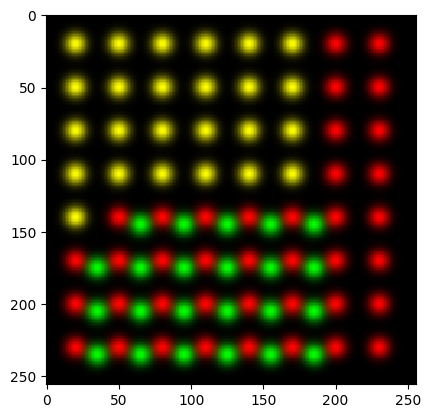

In [4]:
channel1, channel2 = generate_images(0.5)
dip.JoinChannels([channel1, channel2]).Show()

Now we'll run through various values of `overlap`, generate images, and compute colocalization:

In [5]:
for overlap in [0.1, 0.3, 0.5, 0.7, 0.9]:
    channel1, channel2 = generate_images(overlap)
    print()
    print('# Overlap:', overlap)
    coef = dip.PearsonCorrelation(channel1, channel2)
    print('PearsonCorrelation:                ', round(coef, 3))
    coef = dip.MandersOverlapCoefficient(channel1, channel2)
    print('MandersOverlapCoefficient:         ', round(coef, 3))
    coef = dip.IntensityCorrelationQuotient(channel1, channel2)
    print('IntensityCorrelationQuotient:      ', round(coef, 3))
    coef = dip.MandersColocalizationCoefficients(channel1, channel2, None, 0.2, 0.2)
    print('MandersColocalizationCoefficients: ', round(coef[0], 3), round(coef[1], 3))
    coef = dip.CostesColocalizationCoefficients(channel1, channel2)
    print('CostesColocalizationCoefficients:  ', round(coef[0], 3), round(coef[1], 3))


# Overlap: 0.1
PearsonCorrelation:                 -0.046
MandersOverlapCoefficient:          0.23
IntensityCorrelationQuotient:       0.11
MandersColocalizationCoefficients:  0.146 0.195
CostesColocalizationCoefficients:   0.0 0.0

# Overlap: 0.3
PearsonCorrelation:                 0.16
MandersOverlapCoefficient:          0.382
IntensityCorrelationQuotient:       0.177
MandersColocalizationCoefficients:  0.254 0.338
CostesColocalizationCoefficients:   0.089 0.119

# Overlap: 0.5
PearsonCorrelation:                 0.347
MandersOverlapCoefficient:          0.518
IntensityCorrelationQuotient:       0.238
MandersColocalizationCoefficients:  0.351 0.467
CostesColocalizationCoefficients:   0.228 0.304

# Overlap: 0.7
PearsonCorrelation:                 0.553
MandersOverlapCoefficient:          0.669
IntensityCorrelationQuotient:       0.305
MandersColocalizationCoefficients:  0.458 0.611
CostesColocalizationCoefficients:   0.415 0.55

# Overlap: 0.9
PearsonCorrelation:                 0.7

To apply Costes' significance test, we need to estimate the width of the autocorrelation function

In [6]:
ac = dip.AutoCorrelationFT(channel1)
ac = ac > dip.Maximum(ac)[0][0] / 2  # half maximum
ac = dip.Label(ac)
cc = dip.GetImageChainCodes(ac, ac[ac.Size(0)//2, ac.Size(1)//2]) # find central blob
bb = cc[0].BoundingBox()
blockSizes = [bb[1][0] - bb[0][0], bb[1][1] - bb[0][1]] # width and height, corresponds to full width at half maximum
print(blockSizes)

[16, 16]


This width we use as the `blockSizes` parameter to `dip.CostesSignificaneTest`. We explore the region of the `overlap` values that are interesting:

In [7]:
for overlap in [0.00, 0.14, 0.16, 0.18, 0.20, 0.22]:
    channel1, channel2 = generate_images(overlap)
    print(overlap, round(dip.CostesSignificanceTest(channel1, channel2, None, blockSizes, 500), 4))

0.0 0.0
0.14 0.0453
0.16 0.8602
0.18 0.9933
0.2 1.0
0.22 1.0
